In [4]:
from collections import OrderedDict
from typing import List, Tuple, Dict, Optional, Callable, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

from gradient_descent_the_ultimate_optimizer import gdtuo

import flwr as fl
from flwr.common import Metrics
from flwr_datasets import FederatedDataset
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg


DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}
    
    
disable_progress_bar()


Training on cpu using PyTorch 2.3.0+cpu and Flower 1.7.0


In [5]:
NUM_CLIENTS = 7
BATCH_SIZE = 32
TRAIN_VERBOSE = False
TEST_VERBOSE = False
ALPHA = 0.1
MU = 0.3
HYPER_ALPHA = 1e-5
HYPER_MU = 1e-5


def load_datasets():
    fds = FederatedDataset(dataset="cifar10", partitioners={"train" : NUM_CLIENTS})

    def apply_transforms(batch):
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
            ]
        )
        batch["img"] = [transform(img) for img in batch["img"]]
        return batch

    trainloaders = []
    valloaders = []
    for partition_id in range(NUM_CLIENTS):
        partition = fds.load_partition(partition_id, "train")
        partition = partition.with_transform(apply_transforms)
        partition = partition.train_test_split(train_size=0.8)
        trainloaders.append(DataLoader(partition["train"], batch_size=BATCH_SIZE))
        valloaders.append(DataLoader(partition["test"], batch_size=BATCH_SIZE))
    # testset = fds.load_full("test").with_transform(apply_transforms)
    # testloaders = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders#, testloaders

trainloaders, valloaders = load_datasets()   

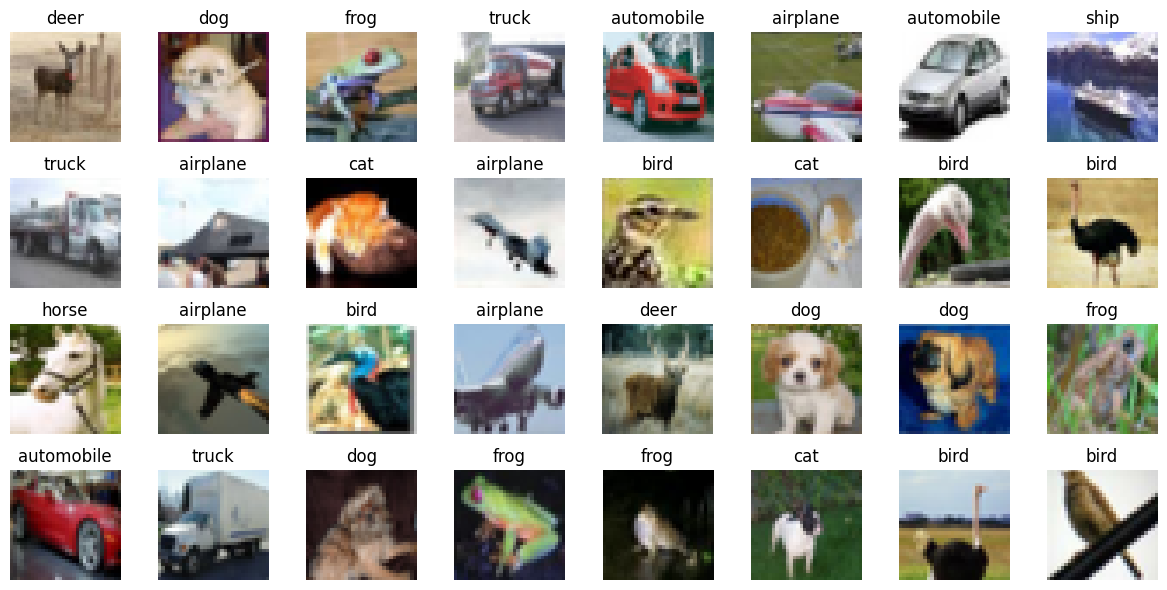

In [6]:
batch = next(iter(trainloaders[0]))
images, labels = batch["img"], batch["label"]

images = images.permute(0, 2, 3, 1).numpy()
images = images / 2 + 0.5

fig, axs = plt.subplots(4, 8, figsize=(12, 6))

for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(trainloaders[0].dataset.features["label"].int2str([labels[i]])[0])
    ax.axis("off")

fig.tight_layout()
plt.show()

In [7]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
                                   nn.Conv2d(3, 32, 3, padding=1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),
                                   )
        self.conv2 = nn.Sequential(
                                   nn.Conv2d(32, 64, 3, padding=1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),
                                   )
        self.conv3 = nn.Sequential(
                                   nn.Conv2d(64, 64, 3, padding=1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),
                                   )
        self.fc = nn.Sequential(
                                nn.Linear(1024, 64),
                                nn.ReLU(),
                                )
        self.clf = nn.Linear(64, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x.flatten(1))
        return self.clf(x)


def train(mw, trainloader, epochs: int, verbose=False):
    criterion = torch.nn.CrossEntropyLoss()
    epoch_loss_dict = []
    mw.initialize()
    mw.set_param()
    for i in range(1, epochs+1):
        running_loss = 0.0
        correct = 0
        total = 0
        for batch in trainloader:
            mw.begin() # call this before each step, enables gradient tracking on desired params
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = mw.forward(images)
            loss = criterion(outputs, labels)
            mw.zero_grad()
            loss.backward(create_graph=True) # important! use create_graph=True
            mw.step()
            running_loss += loss.item()
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        train_loss = running_loss / len(trainloader.dataset)
        epoch_loss_dict.append(train_loss)
        if verbose == True:
            print("EPOCH: {}, TRAIN LOSS: {}, ACCURACY: {}".format(i, train_loss, correct/total))


def test(model, testloader, verbose=True):
    criterion = torch.nn.CrossEntropyLoss()
    correct = 0
    total = 0
    running_loss = 0
    model.set_param()
    with torch.no_grad():
        for batch in testloader:
            image, label = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            output = model.forward(image)
            loss = criterion(output, label)
            running_loss += loss.item()
            total += label.size(0)
            correct += (torch.max(output.data, 1)[1] == label).sum().item()
        train_loss = running_loss / len(testloader.dataset)
    if verbose == True:
        print("EVAL LOSS: {}, ACCURACY: {}".format(train_loss, correct/total))
    
    return train_loss, correct/total


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


    

In [8]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(net=self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] training")
        set_parameters(net=self.net, parameters=parameters)
        train(mw=self.net, trainloader=self.trainloader, epochs=3, verbose=True)
        return get_parameters(net=self.net), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate")
        set_parameters(net=self.net, parameters=parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    model = Net().to(DEVICE)
    optim = gdtuo.SGD(alpha=ALPHA, mu=MU, height=0, optimizer=gdtuo.SGD(alpha=HYPER_ALPHA, mu=HYPER_MU, height=1))
    mw = gdtuo.ModuleWrapper(model, optimizer=optim)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, mw, trainloader, valloader).to_client()

In [9]:
class FedPopsicle(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 1,
        min_evaluate_clients: int = 1,
        min_available_clients: int = 1,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients

    def __repr__(self) -> str:
        return "FedPopsicle"

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        print("Initializing Parameters")
        model = Net().to(DEVICE)
        optim = gdtuo.SGD(alpha=ALPHA, mu=MU, height=0, optimizer=gdtuo.SGD(alpha=HYPER_ALPHA, mu=HYPER_MU, height=1))
        mw = gdtuo.ModuleWrapper(model, optimizer=optim)
        mw.initialize()
        ndarrays_model = get_parameters(mw)
        return fl.common.ndarrays_to_parameters(ndarrays_model)

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated
    
    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""

        # Sample clients
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        config = {}
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))
        return fit_configurations

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        accuracy_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.metrics['accuracy'])
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {"accuracy agg": float(accuracy_aggregated)}
        return loss_aggregated, metrics_aggregated

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate global model parameters using an evaluation function."""
        # model = Net().to(DEVICE)
        # optim = gdtuo.SGD(alpha=0.1, mu=0.3, height=0, optimizer=gdtuo.SGD(alpha=1e-5, mu=1e-5, height=1))
        # mw = gdtuo.ModuleWrapper(model, optimizer=optim)
        # mw.initialize()
        # set_parameters(net=mw, parameters=parameters)
        # loss, accuracy = test(mw, valloaders)
        
        # Let's assume we won't perform the global model evaluation on the server side.
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

In [10]:
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=25),  # Just three rounds
    strategy=FedPopsicle(),
    client_resources=client_resources,
)

INFO flwr 2024-05-04 17:23:52,401 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=25, round_timeout=None)
2024-05-04 17:23:58,023	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-05-04 17:24:01,084 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'object_store_memory': 1583244902.0, 'memory': 3166489806.0, 'GPU': 1.0, 'node:__internal_head__': 1.0, 'CPU': 12.0}
INFO flwr 2024-05-04 17:24:01,084 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-05-04 17:24:01,085 | app.py:227 | No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2024-05-04 17:24:01,085 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-05-04 17:24:01,104 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 12 actors
INFO flwr 2024-05-04 17:24:01,105 | serve

Initializing Parameters


(pid=21160) WARNING:tensorflow:From c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.
(pid=21160) 


(DefaultActor pid=16328) [Client 1] training


(DefaultActor pid=16328) c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ..\torch\csrc\autograd\engine.cpp:1208.)
(DefaultActor pid=16328)   return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
(pid=18288) WARNING:tensorflow:From c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead. [repeated 11x across cluster] (Ray deduplicates 

(DefaultActor pid=16328) EPOCH: 1, TRAIN LOSS: 0.06712994817090193, ACCURACY: 0.19373468673433672
(DefaultActor pid=18288) [Client 2] training [repeated 6x across cluster]
(DefaultActor pid=5156) EPOCH: 2, TRAIN LOSS: 0.056329733328416134, ACCURACY: 0.33204971118501664 [repeated 7x across cluster]
(DefaultActor pid=5156) EPOCH: 3, TRAIN LOSS: 0.04975753109696741, ACCURACY: 0.41554349728688955 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:25:45,171 | server.py:236 | fit_round 1 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:25:45,207 | server.py:173 | evaluate_round 1: strategy sampled 7 clients (out of 7)


(DefaultActor pid=16328) [Client 2] evaluate


DEBUG flwr 2024-05-04 17:25:48,517 | server.py:187 | evaluate_round 1 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:25:48,518 | server.py:222 | fit_round 2: strategy sampled 7 clients (out of 7)


(DefaultActor pid=16328) EVAL LOSS: 0.04715743333497525, ACCURACY: 0.4912526242127362
(DefaultActor pid=5156) [Client 2] training
(DefaultActor pid=23532) EPOCH: 1, TRAIN LOSS: 0.04758303080733356, ACCURACY: 0.4366468323416171 [repeated 7x across cluster]
(DefaultActor pid=18288) [Client 4] evaluate [repeated 6x across cluster]
(DefaultActor pid=5156) EVAL LOSS: 0.046470380480094255, ACCURACY: 0.4926522043386984 [repeated 6x across cluster]
(DefaultActor pid=18288) [Client 4] training [repeated 6x across cluster]
(DefaultActor pid=23532) EPOCH: 2, TRAIN LOSS: 0.04305892835391081, ACCURACY: 0.5033251662583129 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:26:46,483 | server.py:236 | fit_round 2 received 7 results and 0 failures


(DefaultActor pid=23532) EPOCH: 3, TRAIN LOSS: 0.038745781321353666, ACCURACY: 0.5551277563878194 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:26:46,500 | server.py:173 | evaluate_round 2: strategy sampled 7 clients (out of 7)


(DefaultActor pid=16328) [Client 6] evaluate


DEBUG flwr 2024-05-04 17:26:49,340 | server.py:187 | evaluate_round 2 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:26:49,341 | server.py:222 | fit_round 3: strategy sampled 7 clients (out of 7)


(DefaultActor pid=16328) EVAL LOSS: 0.038438174839700495, ACCURACY: 0.5542337298810357
(DefaultActor pid=23532) [Client 2] training
(DefaultActor pid=16328) EPOCH: 1, TRAIN LOSS: 0.03989953987657669, ACCURACY: 0.539901995099755 [repeated 7x across cluster]
(DefaultActor pid=23532) [Client 3] evaluate [repeated 6x across cluster]
(DefaultActor pid=23532) EVAL LOSS: 0.03825729897674603, ACCURACY: 0.5605318404478656 [repeated 6x across cluster]
(DefaultActor pid=29144) [Client 5] training [repeated 6x across cluster]
(DefaultActor pid=31324) EPOCH: 2, TRAIN LOSS: 0.03408518763201029, ACCURACY: 0.6083304165208261 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:27:46,553 | server.py:236 | fit_round 3 received 7 results and 0 failures


(DefaultActor pid=31324) EPOCH: 3, TRAIN LOSS: 0.029315784182379952, ACCURACY: 0.6690584529226461 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:27:46,567 | server.py:173 | evaluate_round 3: strategy sampled 7 clients (out of 7)


(DefaultActor pid=29144) [Client 0] evaluate


DEBUG flwr 2024-05-04 17:27:49,268 | server.py:187 | evaluate_round 3 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:27:49,269 | server.py:222 | fit_round 4: strategy sampled 7 clients (out of 7)


(DefaultActor pid=16328) EVAL LOSS: 0.033706968359550116, ACCURACY: 0.6270118964310707
(DefaultActor pid=31324) [Client 1] training
(DefaultActor pid=23532) EPOCH: 1, TRAIN LOSS: 0.03349011555434024, ACCURACY: 0.6230311515575779 [repeated 7x across cluster]
(DefaultActor pid=23532) [Client 5] evaluate [repeated 6x across cluster]
(DefaultActor pid=18288) EVAL LOSS: 0.03471419442525854, ACCURACY: 0.622813156053184 [repeated 6x across cluster]
(DefaultActor pid=18288) [Client 0] training [repeated 6x across cluster]
(DefaultActor pid=31324) EPOCH: 2, TRAIN LOSS: 0.02781166708423493, ACCURACY: 0.6797339866993349 [repeated 7x across cluster]
(DefaultActor pid=31324) EPOCH: 3, TRAIN LOSS: 0.022486315606605935, ACCURACY: 0.7446622331116556 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:28:46,060 | server.py:236 | fit_round 4 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:28:46,089 | server.py:173 | evaluate_round 4: strategy sampled 7 clients (out of 7)


(DefaultActor pid=16328) [Client 3] evaluate


DEBUG flwr 2024-05-04 17:28:48,715 | server.py:187 | evaluate_round 4 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:28:48,717 | server.py:222 | fit_round 5: strategy sampled 7 clients (out of 7)


(DefaultActor pid=5156) EVAL LOSS: 0.031034192749467907, ACCURACY: 0.6724982505248426
(DefaultActor pid=23532) [Client 3] training
(DefaultActor pid=23532) EPOCH: 1, TRAIN LOSS: 0.029835314132301883, ACCURACY: 0.6587329366468323 [repeated 7x across cluster]
(DefaultActor pid=18288) [Client 6] evaluate [repeated 6x across cluster]
(DefaultActor pid=18288) EVAL LOSS: 0.031991596193560526, ACCURACY: 0.6655003498950315 [repeated 6x across cluster]
(DefaultActor pid=19292) [Client 5] training [repeated 6x across cluster]
(DefaultActor pid=23532) EPOCH: 2, TRAIN LOSS: 0.021766260657479056, ACCURACY: 0.7586629331466573 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:29:45,196 | server.py:236 | fit_round 5 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:29:45,209 | server.py:173 | evaluate_round 5: strategy sampled 7 clients (out of 7)


(DefaultActor pid=31324) EPOCH: 3, TRAIN LOSS: 0.01672045758993508, ACCURACY: 0.8179908995449773 [repeated 7x across cluster]
(DefaultActor pid=16328) [Client 5] evaluate


DEBUG flwr 2024-05-04 17:29:47,670 | server.py:187 | evaluate_round 5 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:29:47,670 | server.py:222 | fit_round 6: strategy sampled 7 clients (out of 7)


(DefaultActor pid=18288) EVAL LOSS: 0.03217514594423763, ACCURACY: 0.6773967809657103
(DefaultActor pid=23532) [Client 0] training
(DefaultActor pid=19292) EPOCH: 1, TRAIN LOSS: 0.026691631400631074, ACCURACY: 0.695834791739587 [repeated 7x across cluster]
(DefaultActor pid=19292) [Client 3] evaluate [repeated 6x across cluster]
(DefaultActor pid=19292) EVAL LOSS: 0.03263956794294967, ACCURACY: 0.6745976207137858 [repeated 6x across cluster]
(DefaultActor pid=18288) [Client 5] training [repeated 6x across cluster]
(DefaultActor pid=19292) EPOCH: 2, TRAIN LOSS: 0.01744460897102279, ACCURACY: 0.8024151207560378 [repeated 7x across cluster]
(DefaultActor pid=19292) EPOCH: 3, TRAIN LOSS: 0.01209792768466001, ACCURACY: 0.871193559677984 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:30:43,979 | server.py:236 | fit_round 6 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:30:43,995 | server.py:173 | evaluate_round 6: strategy sampled 7 clients (out of 7)


(DefaultActor pid=31324) [Client 1] evaluate


DEBUG flwr 2024-05-04 17:30:47,041 | server.py:187 | evaluate_round 6 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:30:47,042 | server.py:222 | fit_round 7: strategy sampled 7 clients (out of 7)


(DefaultActor pid=29144) EVAL LOSS: 0.0333512967036603, ACCURACY: 0.6780965710286914
(DefaultActor pid=16328) [Client 5] training
(DefaultActor pid=16328) EPOCH: 1, TRAIN LOSS: 0.02405504274710434, ACCURACY: 0.7345117255862793 [repeated 7x across cluster]
(DefaultActor pid=19292) [Client 2] evaluate [repeated 6x across cluster]
(DefaultActor pid=18288) EVAL LOSS: 0.031220624232475704, ACCURACY: 0.6927921623512946 [repeated 6x across cluster]
(DefaultActor pid=29144) [Client 0] training [repeated 6x across cluster]
(DefaultActor pid=19292) EPOCH: 2, TRAIN LOSS: 0.014176504998762874, ACCURACY: 0.8454672733636682 [repeated 7x across cluster]
(DefaultActor pid=16328) EPOCH: 3, TRAIN LOSS: 0.009018885861661078, ACCURACY: 0.9068953447672383 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:31:47,436 | server.py:236 | fit_round 7 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:31:47,449 | server.py:173 | evaluate_round 7: strategy sampled 7 clients (out of 7)


(DefaultActor pid=31324) [Client 6] evaluate


DEBUG flwr 2024-05-04 17:31:50,052 | server.py:187 | evaluate_round 7 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:31:50,054 | server.py:222 | fit_round 8: strategy sampled 7 clients (out of 7)


(DefaultActor pid=16328) EVAL LOSS: 0.03331593237947633, ACCURACY: 0.6983904828551435
(DefaultActor pid=16328) [Client 0] training
(DefaultActor pid=16328) EPOCH: 1, TRAIN LOSS: 0.0221891411334683, ACCURACY: 0.7555127756387819 [repeated 7x across cluster]
(DefaultActor pid=19292) [Client 0] evaluate [repeated 6x across cluster]
(DefaultActor pid=18288) EVAL LOSS: 0.032611340075793846, ACCURACY: 0.7025892232330301 [repeated 6x across cluster]
(DefaultActor pid=31324) [Client 6] training [repeated 6x across cluster]
(DefaultActor pid=16328) EPOCH: 2, TRAIN LOSS: 0.01139515779956805, ACCURACY: 0.8781939096954847 [repeated 7x across cluster]
(DefaultActor pid=16328) EPOCH: 3, TRAIN LOSS: 0.006826585446219366, ACCURACY: 0.9301715085754287 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:32:47,720 | server.py:236 | fit_round 8 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:32:47,734 | server.py:173 | evaluate_round 8: strategy sampled 7 clients (out of 7)


(DefaultActor pid=5156) [Client 4] evaluate


DEBUG flwr 2024-05-04 17:32:50,396 | server.py:187 | evaluate_round 8 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:32:50,397 | server.py:222 | fit_round 9: strategy sampled 7 clients (out of 7)


(DefaultActor pid=5156) EVAL LOSS: 0.037253934011499394, ACCURACY: 0.6934919524142757
(DefaultActor pid=16328) [Client 1] training
(DefaultActor pid=31324) EPOCH: 1, TRAIN LOSS: 0.02007656139450387, ACCURACY: 0.7826391319565978 [repeated 7x across cluster]
(DefaultActor pid=16328) [Client 5] evaluate [repeated 6x across cluster]
(DefaultActor pid=31324) EVAL LOSS: 0.03745361676659928, ACCURACY: 0.695591322603219 [repeated 6x across cluster]
(DefaultActor pid=18288) [Client 3] training [repeated 6x across cluster]
(DefaultActor pid=31324) EPOCH: 2, TRAIN LOSS: 0.009694476425126169, ACCURACY: 0.8970948547427371 [repeated 7x across cluster]
(DefaultActor pid=16328) EPOCH: 3, TRAIN LOSS: 0.005582837176032946, ACCURACY: 0.9446972348617431 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:33:51,343 | server.py:236 | fit_round 9 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:33:51,358 | server.py:173 | evaluate_round 9: strategy sampled 7 clients (out of 7)


(DefaultActor pid=31324) [Client 0] evaluate
(DefaultActor pid=23532) EVAL LOSS: 0.03558103849705989, ACCURACY: 0.7032890132960112


DEBUG flwr 2024-05-04 17:33:54,646 | server.py:187 | evaluate_round 9 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:33:54,648 | server.py:222 | fit_round 10: strategy sampled 7 clients (out of 7)


(DefaultActor pid=16328) [Client 4] training
(DefaultActor pid=29144) EPOCH: 1, TRAIN LOSS: 0.018224717740792262, ACCURACY: 0.7952397619880994 [repeated 7x across cluster]
(DefaultActor pid=5156) [Client 3] evaluate [repeated 6x across cluster]
(DefaultActor pid=5156) EVAL LOSS: 0.038676235290404544, ACCURACY: 0.6962911126662001 [repeated 6x across cluster]
(DefaultActor pid=18288) [Client 5] training [repeated 6x across cluster]
(DefaultActor pid=29144) EPOCH: 2, TRAIN LOSS: 0.007943935754246382, ACCURACY: 0.9163458172908645 [repeated 7x across cluster]
(DefaultActor pid=29144) EPOCH: 3, TRAIN LOSS: 0.0037253970344833533, ACCURACY: 0.9670983549177459 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:34:56,112 | server.py:236 | fit_round 10 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:34:56,128 | server.py:173 | evaluate_round 10: strategy sampled 7 clients (out of 7)


(DefaultActor pid=19292) [Client 0] evaluate


DEBUG flwr 2024-05-04 17:34:58,539 | server.py:187 | evaluate_round 10 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:34:58,540 | server.py:222 | fit_round 11: strategy sampled 7 clients (out of 7)


(DefaultActor pid=16328) EVAL LOSS: 0.037271695705541286, ACCURACY: 0.7060881735479356
(DefaultActor pid=19292) EPOCH: 3, TRAIN LOSS: 0.004571910753277661, ACCURACY: 0.9546727336366818 [repeated 6x across cluster]
(DefaultActor pid=16328) [Client 4] training
(DefaultActor pid=18288) [Client 6] evaluate [repeated 6x across cluster]
(DefaultActor pid=18288) EVAL LOSS: 0.04064332223005275, ACCURACY: 0.6997900629811057 [repeated 6x across cluster]
(DefaultActor pid=18288) EPOCH: 1, TRAIN LOSS: 0.017208086399085713, ACCURACY: 0.803465173258663
(DefaultActor pid=23532) [Client 3] training [repeated 6x across cluster]
(DefaultActor pid=31324) EPOCH: 1, TRAIN LOSS: 0.016890065308608756, ACCURACY: 0.807806756520217
(DefaultActor pid=31324) EPOCH: 2, TRAIN LOSS: 0.006716017862535725, ACCURACY: 0.9275336950813933 [repeated 6x across cluster]


DEBUG flwr 2024-05-04 17:35:56,301 | server.py:236 | fit_round 11 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:35:56,318 | server.py:173 | evaluate_round 11: strategy sampled 7 clients (out of 7)


(DefaultActor pid=16328) EPOCH: 3, TRAIN LOSS: 0.003785370962839674, ACCURACY: 0.9620231011550577 [repeated 7x across cluster]
(DefaultActor pid=16328) [Client 4] evaluate


DEBUG flwr 2024-05-04 17:35:58,948 | server.py:187 | evaluate_round 11 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:35:58,949 | server.py:222 | fit_round 12: strategy sampled 7 clients (out of 7)


(DefaultActor pid=31324) EVAL LOSS: 0.03875167545861844, ACCURACY: 0.7060881735479356
(DefaultActor pid=16328) [Client 0] training
(DefaultActor pid=16328) EPOCH: 1, TRAIN LOSS: 0.015481149670196906, ACCURACY: 0.8246412320616031 [repeated 7x across cluster]
(DefaultActor pid=18288) [Client 2] evaluate [repeated 6x across cluster]
(DefaultActor pid=16328) EVAL LOSS: 0.04124243301974884, ACCURACY: 0.6997900629811057 [repeated 6x across cluster]
(DefaultActor pid=23532) [Client 1] training [repeated 6x across cluster]
(DefaultActor pid=16328) EPOCH: 2, TRAIN LOSS: 0.006529157747223446, ACCURACY: 0.9261463073153657 [repeated 7x across cluster]
(DefaultActor pid=16328) EPOCH: 3, TRAIN LOSS: 0.003389015016665941, ACCURACY: 0.9648232411620581 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:36:55,850 | server.py:236 | fit_round 12 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:36:55,863 | server.py:173 | evaluate_round 12: strategy sampled 7 clients (out of 7)


(DefaultActor pid=31324) [Client 6] evaluate


DEBUG flwr 2024-05-04 17:36:58,390 | server.py:187 | evaluate_round 12 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:36:58,391 | server.py:222 | fit_round 13: strategy sampled 7 clients (out of 7)


(DefaultActor pid=31324) EVAL LOSS: 0.04307254387666663, ACCURACY: 0.7053883834849545
(DefaultActor pid=16328) [Client 3] training
(DefaultActor pid=16328) EPOCH: 1, TRAIN LOSS: 0.013414030457173022, ACCURACY: 0.8452922646132307 [repeated 7x across cluster]
(DefaultActor pid=19292) [Client 0] evaluate [repeated 6x across cluster]
(DefaultActor pid=18288) EVAL LOSS: 0.0399776545123173, ACCURACY: 0.7109867039888034 [repeated 6x across cluster]
(DefaultActor pid=29144) [Client 0] training [repeated 6x across cluster]
(DefaultActor pid=16328) EPOCH: 2, TRAIN LOSS: 0.005090667045028801, ACCURACY: 0.9481974098704935 [repeated 7x across cluster]
(DefaultActor pid=16328) EPOCH: 3, TRAIN LOSS: 0.0022777050261222425, ACCURACY: 0.9775988799439972 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:37:54,451 | server.py:236 | fit_round 13 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:37:54,469 | server.py:173 | evaluate_round 13: strategy sampled 7 clients (out of 7)


(DefaultActor pid=31324) [Client 2] evaluate
(DefaultActor pid=31324) EVAL LOSS: 0.04240727925150439, ACCURACY: 0.7214835549335199


DEBUG flwr 2024-05-04 17:37:57,209 | server.py:187 | evaluate_round 13 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:37:57,211 | server.py:222 | fit_round 14: strategy sampled 7 clients (out of 7)


(DefaultActor pid=16328) [Client 1] training
(DefaultActor pid=16328) EPOCH: 1, TRAIN LOSS: 0.012400956852456093, ACCURACY: 0.8584179208960449 [repeated 7x across cluster]
(DefaultActor pid=18288) [Client 5] evaluate [repeated 6x across cluster]
(DefaultActor pid=18288) EVAL LOSS: 0.04154161492622007, ACCURACY: 0.7158852344296711 [repeated 6x across cluster]
(DefaultActor pid=31324) [Client 0] training [repeated 6x across cluster]
(DefaultActor pid=16328) EPOCH: 2, TRAIN LOSS: 0.004884990586093726, ACCURACY: 0.9467973398669933 [repeated 7x across cluster]
(DefaultActor pid=16328) EPOCH: 3, TRAIN LOSS: 0.0023294963980192043, ACCURACY: 0.9770738536926846 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:38:51,928 | server.py:236 | fit_round 14 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:38:51,945 | server.py:173 | evaluate_round 14: strategy sampled 7 clients (out of 7)


(DefaultActor pid=31324) [Client 0] evaluate


DEBUG flwr 2024-05-04 17:38:54,520 | server.py:187 | evaluate_round 14 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:38:54,521 | server.py:222 | fit_round 15: strategy sampled 7 clients (out of 7)


(DefaultActor pid=31324) EVAL LOSS: 0.04577619848841967, ACCURACY: 0.6969909027291813
(DefaultActor pid=16328) [Client 6] training
(DefaultActor pid=16328) EPOCH: 1, TRAIN LOSS: 0.010968861280150325, ACCURACY: 0.8716961316296167 [repeated 7x across cluster]
(DefaultActor pid=16328) [Client 4] evaluate [repeated 6x across cluster]
(DefaultActor pid=16328) EVAL LOSS: 0.04623399296367477, ACCURACY: 0.7046885934219734 [repeated 6x across cluster]
(DefaultActor pid=18288) [Client 3] training [repeated 6x across cluster]
(DefaultActor pid=16328) EPOCH: 2, TRAIN LOSS: 0.0043148157733242975, ACCURACY: 0.9548398389637669 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:39:50,509 | server.py:236 | fit_round 15 received 7 results and 0 failures


(DefaultActor pid=16328) EPOCH: 3, TRAIN LOSS: 0.0019254987349783593, ACCURACY: 0.9830211797654472 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:39:50,531 | server.py:173 | evaluate_round 15: strategy sampled 7 clients (out of 7)


(DefaultActor pid=5156) [Client 3] evaluate


DEBUG flwr 2024-05-04 17:39:53,186 | server.py:187 | evaluate_round 15 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:39:53,186 | server.py:222 | fit_round 16: strategy sampled 7 clients (out of 7)


(DefaultActor pid=5156) EVAL LOSS: 0.047979121778793814, ACCURACY: 0.6962911126662001
(DefaultActor pid=16328) [Client 1] training
(DefaultActor pid=31324) EPOCH: 1, TRAIN LOSS: 0.010569422731699541, ACCURACY: 0.8794189709485474 [repeated 7x across cluster]
(DefaultActor pid=23532) [Client 0] evaluate [repeated 6x across cluster]
(DefaultActor pid=16328) EVAL LOSS: 0.04674195859547342, ACCURACY: 0.701889433170049 [repeated 6x across cluster]
(DefaultActor pid=18288) [Client 6] training [repeated 6x across cluster]
(DefaultActor pid=16328) EPOCH: 2, TRAIN LOSS: 0.004056788418809716, ACCURACY: 0.9569478473923696 [repeated 7x across cluster]
(DefaultActor pid=16328) EPOCH: 3, TRAIN LOSS: 0.0016362930198259048, ACCURACY: 0.9884494224711236 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:40:49,849 | server.py:236 | fit_round 16 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:40:49,862 | server.py:173 | evaluate_round 16: strategy sampled 7 clients (out of 7)


(DefaultActor pid=18288) [Client 5] evaluate


DEBUG flwr 2024-05-04 17:40:52,488 | server.py:187 | evaluate_round 16 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:40:52,489 | server.py:222 | fit_round 17: strategy sampled 7 clients (out of 7)


(DefaultActor pid=31324) EVAL LOSS: 0.04881775233193325, ACCURACY: 0.7004898530440867
(DefaultActor pid=16328) [Client 4] training
(DefaultActor pid=5156) EPOCH: 1, TRAIN LOSS: 0.008511904859018933, ACCURACY: 0.9014700735036751 [repeated 7x across cluster]
(DefaultActor pid=29144) [Client 4] evaluate [repeated 6x across cluster]
(DefaultActor pid=5156) EVAL LOSS: 0.04429885964029898, ACCURACY: 0.7333799860041987 [repeated 6x across cluster]
(DefaultActor pid=18288) [Client 3] training [repeated 6x across cluster]
(DefaultActor pid=16328) EPOCH: 2, TRAIN LOSS: 0.002826326446184588, ACCURACY: 0.9733986699334967 [repeated 7x across cluster]
(DefaultActor pid=23532) EPOCH: 3, TRAIN LOSS: 0.0016927529059079227, ACCURACY: 0.9858218099072291 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:41:48,284 | server.py:236 | fit_round 17 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:41:48,304 | server.py:173 | evaluate_round 17: strategy sampled 7 clients (out of 7)


(DefaultActor pid=16328) [Client 5] evaluate


DEBUG flwr 2024-05-04 17:41:50,786 | server.py:187 | evaluate_round 17 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:41:50,786 | server.py:222 | fit_round 18: strategy sampled 7 clients (out of 7)


(DefaultActor pid=18288) EVAL LOSS: 0.04978035330939243, ACCURACY: 0.7123862841147656
(DefaultActor pid=5156) [Client 0] training
(DefaultActor pid=23532) EPOCH: 1, TRAIN LOSS: 0.008112340780887146, ACCURACY: 0.9067203360168008 [repeated 7x across cluster]
(DefaultActor pid=18288) [Client 2] evaluate [repeated 6x across cluster]
(DefaultActor pid=19292) EVAL LOSS: 0.05125989878069195, ACCURACY: 0.7053883834849545 [repeated 6x across cluster]
(DefaultActor pid=18288) [Client 4] training [repeated 6x across cluster]
(DefaultActor pid=16328) EPOCH: 2, TRAIN LOSS: 0.0028996794706384567, ACCURACY: 0.9716485824291214 [repeated 7x across cluster]
(DefaultActor pid=16328) EPOCH: 3, TRAIN LOSS: 0.0010725779926334597, ACCURACY: 0.9924746237311866 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:42:45,856 | server.py:236 | fit_round 18 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:42:45,876 | server.py:173 | evaluate_round 18: strategy sampled 7 clients (out of 7)


(DefaultActor pid=5156) [Client 6] evaluate


DEBUG flwr 2024-05-04 17:42:48,308 | server.py:187 | evaluate_round 18 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:42:48,308 | server.py:222 | fit_round 19: strategy sampled 7 clients (out of 7)


(DefaultActor pid=16328) EVAL LOSS: 0.05153901027248321, ACCURACY: 0.6983904828551435
(DefaultActor pid=23532) [Client 4] training
(DefaultActor pid=18288) EPOCH: 3, TRAIN LOSS: 0.001694019671821609, ACCURACY: 0.9835491774588729 [repeated 6x across cluster]
(DefaultActor pid=23532) [Client 3] evaluate [repeated 6x across cluster]
(DefaultActor pid=18288) EVAL LOSS: 0.04895587986044487, ACCURACY: 0.70888733379986 [repeated 6x across cluster]
(DefaultActor pid=31324) [Client 2] training [repeated 6x across cluster]
(DefaultActor pid=23532) EPOCH: 1, TRAIN LOSS: 0.006948773090368724, ACCURACY: 0.9208960448022401
(DefaultActor pid=19292) EPOCH: 1, TRAIN LOSS: 0.007752673884956078, ACCURACY: 0.9156457822891144
(DefaultActor pid=19292) EPOCH: 2, TRAIN LOSS: 0.0028929703764286247, ACCURACY: 0.9691984599229961 [repeated 6x across cluster]
(DefaultActor pid=19292) EPOCH: 3, TRAIN LOSS: 0.0011642602830000631, ACCURACY: 0.9908995449772489 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:43:46,775 | server.py:236 | fit_round 19 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:43:46,796 | server.py:173 | evaluate_round 19: strategy sampled 7 clients (out of 7)


(DefaultActor pid=31324) [Client 5] evaluate


DEBUG flwr 2024-05-04 17:43:49,393 | server.py:187 | evaluate_round 19 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:43:49,394 | server.py:222 | fit_round 20: strategy sampled 7 clients (out of 7)


(DefaultActor pid=31324) EVAL LOSS: 0.049722997165376946, ACCURACY: 0.7116864940517844
(DefaultActor pid=16328) [Client 1] training
(DefaultActor pid=16328) EPOCH: 1, TRAIN LOSS: 0.0067203189723916016, ACCURACY: 0.9215960798039902 [repeated 7x across cluster]
(DefaultActor pid=19292) [Client 3] evaluate [repeated 6x across cluster]
(DefaultActor pid=19292) EVAL LOSS: 0.053569514990019745, ACCURACY: 0.6997900629811057 [repeated 6x across cluster]
(DefaultActor pid=31324) [Client 3] training [repeated 6x across cluster]
(DefaultActor pid=5156) EPOCH: 2, TRAIN LOSS: 0.0022306448024054445, ACCURACY: 0.9788239411970598 [repeated 7x across cluster]
(DefaultActor pid=5156) EPOCH: 3, TRAIN LOSS: 0.0009677324809233756, ACCURACY: 0.9929996499824991 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:44:49,455 | server.py:236 | fit_round 20 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:44:49,476 | server.py:173 | evaluate_round 20: strategy sampled 7 clients (out of 7)


(DefaultActor pid=31324) [Client 5] evaluate


DEBUG flwr 2024-05-04 17:44:52,013 | server.py:187 | evaluate_round 20 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:44:52,014 | server.py:222 | fit_round 21: strategy sampled 7 clients (out of 7)


(DefaultActor pid=31324) EVAL LOSS: 0.05139627752394172, ACCURACY: 0.7123862841147656
(DefaultActor pid=16328) [Client 5] training
(DefaultActor pid=16328) EPOCH: 1, TRAIN LOSS: 0.005624217800743876, ACCURACY: 0.9341967098354917 [repeated 7x across cluster]
(DefaultActor pid=5156) [Client 1] evaluate [repeated 6x across cluster]
(DefaultActor pid=5156) EVAL LOSS: 0.04993136770413254, ACCURACY: 0.7319804058782365 [repeated 6x across cluster]
(DefaultActor pid=18288) [Client 0] training [repeated 6x across cluster]
(DefaultActor pid=23532) EPOCH: 2, TRAIN LOSS: 0.0024095072108981, ACCURACY: 0.9768988449422471 [repeated 7x across cluster]
(DefaultActor pid=16328) EPOCH: 3, TRAIN LOSS: 0.0011749739390639813, ACCURACY: 0.9898494924746237 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:45:47,151 | server.py:236 | fit_round 21 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:45:47,167 | server.py:173 | evaluate_round 21: strategy sampled 7 clients (out of 7)


(DefaultActor pid=5156) [Client 2] evaluate


DEBUG flwr 2024-05-04 17:45:49,701 | server.py:187 | evaluate_round 21 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:45:49,702 | server.py:222 | fit_round 22: strategy sampled 7 clients (out of 7)


(DefaultActor pid=18288) EVAL LOSS: 0.05300537162597902, ACCURACY: 0.7123862841147656
(DefaultActor pid=16328) [Client 1] training
(DefaultActor pid=16328) EPOCH: 1, TRAIN LOSS: 0.004825280985958277, ACCURACY: 0.9448722436121806 [repeated 7x across cluster]
(DefaultActor pid=16328) [Client 4] evaluate [repeated 6x across cluster]
(DefaultActor pid=19292) EVAL LOSS: 0.05649140274883401, ACCURACY: 0.7032890132960112 [repeated 6x across cluster]
(DefaultActor pid=18288) [Client 3] training [repeated 6x across cluster]
(DefaultActor pid=16328) EPOCH: 2, TRAIN LOSS: 0.0028241382094245505, ACCURACY: 0.9693734686734337 [repeated 7x across cluster]
(DefaultActor pid=16328) EPOCH: 3, TRAIN LOSS: 0.0009355662551093723, ACCURACY: 0.991949597479874 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:46:50,025 | server.py:236 | fit_round 22 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:46:50,041 | server.py:173 | evaluate_round 22: strategy sampled 7 clients (out of 7)


(DefaultActor pid=29144) [Client 0] evaluate


DEBUG flwr 2024-05-04 17:46:52,552 | server.py:187 | evaluate_round 22 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:46:52,552 | server.py:222 | fit_round 23: strategy sampled 7 clients (out of 7)


(DefaultActor pid=16328) EVAL LOSS: 0.054079445406137606, ACCURACY: 0.7102869139258222
(DefaultActor pid=16328) [Client 6] training
(DefaultActor pid=23532) EPOCH: 1, TRAIN LOSS: 0.0033265870196681558, ACCURACY: 0.9627231361568078 [repeated 7x across cluster]
(DefaultActor pid=19292) [Client 4] evaluate [repeated 6x across cluster]
(DefaultActor pid=18288) EVAL LOSS: 0.052217648736741513, ACCURACY: 0.7298810356892932 [repeated 6x across cluster]
(DefaultActor pid=18288) [Client 1] training [repeated 6x across cluster]
(DefaultActor pid=16328) EPOCH: 2, TRAIN LOSS: 0.0017573030431748855, ACCURACY: 0.98337125853317 [repeated 7x across cluster]
(DefaultActor pid=19292) EPOCH: 3, TRAIN LOSS: 0.0006048218566353218, ACCURACY: 0.9966748337416871 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:47:47,659 | server.py:236 | fit_round 23 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:47:47,675 | server.py:173 | evaluate_round 23: strategy sampled 7 clients (out of 7)


(DefaultActor pid=16328) [Client 2] evaluate


DEBUG flwr 2024-05-04 17:47:50,335 | server.py:187 | evaluate_round 23 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:47:50,336 | server.py:222 | fit_round 24: strategy sampled 7 clients (out of 7)


(DefaultActor pid=16328) EVAL LOSS: 0.05895585854041818, ACCURACY: 0.7109867039888034
(DefaultActor pid=5156) [Client 1] training
(DefaultActor pid=16328) EPOCH: 1, TRAIN LOSS: 0.003842838273729541, ACCURACY: 0.9567728386419321 [repeated 7x across cluster]
(DefaultActor pid=18288) [Client 0] evaluate [repeated 6x across cluster]
(DefaultActor pid=18288) EVAL LOSS: 0.05833499751948576, ACCURACY: 0.6927921623512946 [repeated 6x across cluster]
(DefaultActor pid=18288) [Client 6] training [repeated 6x across cluster]
(DefaultActor pid=16328) EPOCH: 2, TRAIN LOSS: 0.0017587503764760772, ACCURACY: 0.9831991599579979 [repeated 7x across cluster]
(DefaultActor pid=16328) EPOCH: 3, TRAIN LOSS: 0.0005545724889432694, ACCURACY: 0.996324816240812 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:48:46,517 | server.py:236 | fit_round 24 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:48:46,535 | server.py:173 | evaluate_round 24: strategy sampled 7 clients (out of 7)


(DefaultActor pid=31324) [Client 6] evaluate


DEBUG flwr 2024-05-04 17:48:49,154 | server.py:187 | evaluate_round 24 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:48:49,155 | server.py:222 | fit_round 25: strategy sampled 7 clients (out of 7)


(DefaultActor pid=31324) EVAL LOSS: 0.061228713595508445, ACCURACY: 0.7060881735479356
(DefaultActor pid=16328) [Client 0] training
(DefaultActor pid=16328) EPOCH: 1, TRAIN LOSS: 0.0027185177635388447, ACCURACY: 0.9728736436821841 [repeated 7x across cluster]
(DefaultActor pid=18288) [Client 1] evaluate [repeated 6x across cluster]
(DefaultActor pid=19292) EVAL LOSS: 0.057610163390845, ACCURACY: 0.7046885934219734 [repeated 6x across cluster]
(DefaultActor pid=31324) [Client 2] training [repeated 6x across cluster]
(DefaultActor pid=16328) EPOCH: 2, TRAIN LOSS: 0.0015174275929385997, ACCURACY: 0.9861743087154358 [repeated 7x across cluster]
(DefaultActor pid=16328) EPOCH: 3, TRAIN LOSS: 0.000762282211478085, ACCURACY: 0.9942247112355618 [repeated 7x across cluster]


DEBUG flwr 2024-05-04 17:49:46,321 | server.py:236 | fit_round 25 received 7 results and 0 failures
DEBUG flwr 2024-05-04 17:49:46,338 | server.py:173 | evaluate_round 25: strategy sampled 7 clients (out of 7)


(DefaultActor pid=29144) [Client 6] evaluate


DEBUG flwr 2024-05-04 17:49:48,806 | server.py:187 | evaluate_round 25 received 7 results and 0 failures
INFO flwr 2024-05-04 17:49:48,807 | server.py:153 | FL finished in 1547.6888697999966
INFO flwr 2024-05-04 17:49:48,807 | app.py:226 | app_fit: losses_distributed [(1, 0.04673175431365646), (2, 0.03786269260217914), (3, 0.03330595338033531), (4, 0.031467133500058087), (5, 0.03129733208833927), (6, 0.03235849969317695), (7, 0.03363462190061739), (8, 0.03642793498634637), (9, 0.037095852408494445), (10, 0.038914279418802974), (11, 0.040394801003306335), (12, 0.04141468555703469), (13, 0.043527742442424015), (14, 0.04536451001435676), (15, 0.04593851182158799), (16, 0.047269122151628706), (17, 0.0495138453427856), (18, 0.05079961849143239), (19, 0.05158733959902552), (20, 0.05366901695984525), (21, 0.05519569290169332), (22, 0.05633343527832592), (23, 0.058148181731612944), (24, 0.05970429864976569), (25, 0.0617918996206465)]
INFO flwr 2024-05-04 17:49:48,809 | app.py:227 | app_fit: me

(DefaultActor pid=31324) EVAL LOSS: 0.06319353428647767, ACCURACY: 0.708187543736879


History (loss, distributed):
	round 1: 0.04673175431365646
	round 2: 0.03786269260217914
	round 3: 0.03330595338033531
	round 4: 0.031467133500058087
	round 5: 0.03129733208833927
	round 6: 0.03235849969317695
	round 7: 0.03363462190061739
	round 8: 0.03642793498634637
	round 9: 0.037095852408494445
	round 10: 0.038914279418802974
	round 11: 0.040394801003306335
	round 12: 0.04141468555703469
	round 13: 0.043527742442424015
	round 14: 0.04536451001435676
	round 15: 0.04593851182158799
	round 16: 0.047269122151628706
	round 17: 0.0495138453427856
	round 18: 0.05079961849143239
	round 19: 0.05158733959902552
	round 20: 0.05366901695984525
	round 21: 0.05519569290169332
	round 22: 0.05633343527832592
	round 23: 0.058148181731612944
	round 24: 0.05970429864976569
	round 25: 0.0617918996206465
History (metrics, distributed, evaluate):
{'accuracy agg': [(1, 0.4811556533040088), (2, 0.5740277916625012), (3, 0.6362091372588223), (4, 0.6709987003898831), (5, 0.6845946216135159), (6, 0.685494351

(DefaultActor pid=16328) EVAL LOSS: 0.06291223581726522, ACCURACY: 0.6857942617214835
